In [4]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_qubo_graph(G, pos=None, node_size_scale=500):
    plt.figure(figsize=(7, 5))
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    # Parameters
    node_color = [G.nodes[i].get("esg", 0) for i in G.nodes()]
    node_size = [G.degree(i) * node_size_scale for i in G.nodes()]
    edge_width = [abs(G[u][v].get("weight", 0)) * 2 for u, v in G.edges()]

    # Draw the network (no colorbar, no color temperature)
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=node_size, alpha=0.9, edgecolors="black")
    nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6)
    
    # Label nodes with parameters
    labels = {
        i: f"A{i}\nμ={G.nodes[i].get('mu', 0):.3f}\nESG={G.nodes[i].get('esg', 0):.2f}"
        for i in G.nodes()
    }
    nx.draw_networkx_labels(G, pos, labels, font_size=9)
    
    # Edge weight labels (optional)
    edge_labels = {(u, v): f"{G[u][v].get('weight', 0):.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.axis('off')
    plt.title("QUBO Network: Nodes=Assets, Edges=Covariance/Risk Couplings")
    plt.show()

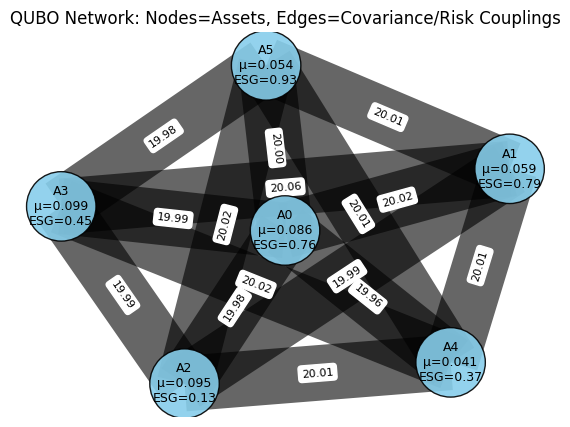

In [5]:
plot_qubo_graph(G)

/tmp/ipykernel_3706/3248070068.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = price_df.pct_change().dropna()


=== Portfolio Graph Analysis ===
Number of assets (nodes): 13
Number of correlations (edges): 33
Graph density: 0.423
Average connections per asset: 5.08
Average ESG score: 7.29
Average absolute correlation: 0.329
Most connected assets: [('SMIN.L', 9), ('SDR.L', 8), ('PRU.L', 7)]

=== Generating QUBO Network Visualization ===


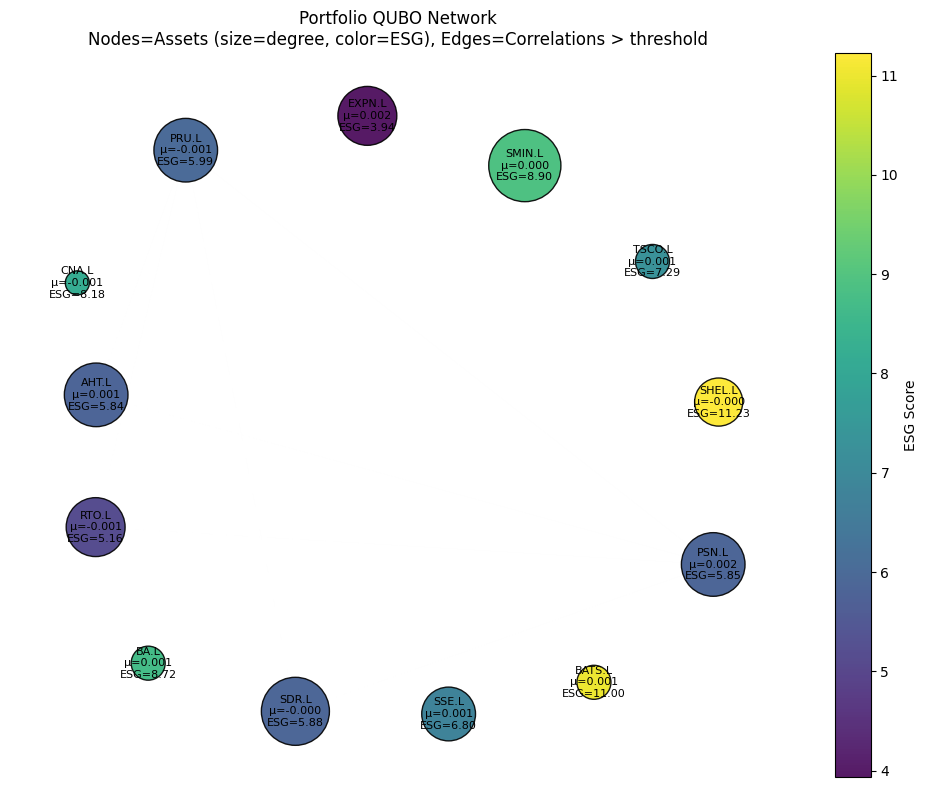


QUBO Matrix shape: (13, 13)
QUBO matrix ready for QAOA optimization!

=== Portfolio Characteristics ===
Assets: ['EXPN.L', 'SHEL.L', 'BA.L', 'CNA.L', 'TSCO.L', 'PRU.L', 'PSN.L', 'SDR.L', 'AHT.L', 'SSE.L', 'BATS.L', 'RTO.L', 'SMIN.L']
Expected returns: [np.float64(0.0017029850335665197), np.float64(-2.4304889545103926e-06), np.float64(0.0009873654702359297), np.float64(-0.0007295207899513823), np.float64(0.0014701442727089356), np.float64(-0.0005527010213243772), np.float64(0.002205309518852913), np.float64(-0.00017531218679703265), np.float64(0.0009208921862476816), np.float64(0.000966185767068925), np.float64(0.0007469472827713539), np.float64(-0.0014398667862351978), np.float64(0.0003460829654439221)]
ESG scores: [np.float64(3.936666666666666), np.float64(11.226666666666667), np.float64(8.716666666666667), np.float64(8.18), np.float64(7.286666666666666), np.float64(5.989999999999999), np.float64(5.853333333333334), np.float64(5.876666666666666), np.float64(5.843333333333334), np.flo

In [6]:
# add the parent directory to Python path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

# load test json in jupyter notebook
import json
with open("./small_dataset.json") as f:
    dic = json.load(f)
    dic = dic["data"] # when run Launcher.ipynb, comment this out

# Parse data into assets and
from utils import json_parse
price_df, esg_s, asset_arr = json_parse(dic)

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

def create_qubo_graph(price_df, esg_s, asset_arr, correlation_threshold=0.3):
    """
    Create a QUBO graph from financial data
    
    Parameters:
    - price_df: DataFrame with price data (assets as columns)
    - esg_s: Series with ESG scores for each asset
    - asset_arr: Array of asset names/identifiers
    - correlation_threshold: Minimum correlation to include edge
    """
    # Calculate returns and correlation matrix
    returns_df = price_df.pct_change().dropna()
    correlation_matrix = returns_df.corr()
    covariance_matrix = returns_df.cov()
    
    # Calculate expected returns (mean returns)
    expected_returns = returns_df.mean()
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes with attributes
    for i, asset in enumerate(asset_arr):
        G.add_node(i, 
                  asset_name=asset,
                  mu=expected_returns.iloc[i] if i < len(expected_returns) else 0,
                  esg=esg_s.iloc[i] if i < len(esg_s) else 0)
    
    # Add edges based on correlation
    for i in range(len(asset_arr)):
        for j in range(i+1, len(asset_arr)):
            corr = correlation_matrix.iloc[i, j]
            cov = covariance_matrix.iloc[i, j]
            
            # Only add edges for significant correlations
            if abs(corr) > correlation_threshold:
                G.add_edge(i, j, weight=cov, correlation=corr)
    
    return G

def plot_qubo_graph(G, pos=None, node_size_scale=500):
    plt.figure(figsize=(10, 8))
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    # Parameters - using ESG scores for node coloring
    node_color = [G.nodes[i].get("esg", 0) for i in G.nodes()]
    node_size = [G.degree(i) * node_size_scale for i in G.nodes()]
    edge_width = [abs(G[u][v].get("weight", 0)) * 5 for u, v in G.edges()]  # Scaled for visibility

    # Draw nodes with ESG-based coloring
    nodes = nx.draw_networkx_nodes(G, pos, 
                                 node_color=node_color, 
                                 node_size=node_size, 
                                 alpha=0.9, 
                                 edgecolors="black",
                                 cmap='viridis')
    
    # Add colorbar for ESG scores
    plt.colorbar(nodes, label='ESG Score')
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, edge_color='gray')
    
    # Label nodes with parameters
    labels = {
        i: f"{G.nodes[i].get('asset_name', f'A{i}')}\nμ={G.nodes[i].get('mu', 0):.3f}\nESG={G.nodes[i].get('esg', 0):.2f}"
        for i in G.nodes()
    }
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    # Edge weight labels (optional - can be commented out for dense graphs)
    if len(G.edges()) < 20:  # Only show edge labels for sparse graphs
        edge_labels = {(u, v): f"{G[u][v].get('correlation', 0):.2f}" for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.axis('off')
    plt.title("Portfolio QUBO Network\nNodes=Assets (size=degree, color=ESG), Edges=Correlations > threshold")
    plt.tight_layout()
    plt.show()
    
    return pos

# Additional analysis functions
def analyze_graph_structure(G):
    """Analyze the graph structure for portfolio insights"""
    print("=== Portfolio Graph Analysis ===")
    print(f"Number of assets (nodes): {G.number_of_nodes()}")
    print(f"Number of correlations (edges): {G.number_of_edges()}")
    print(f"Graph density: {nx.density(G):.3f}")
    
    # Degree analysis
    degrees = [G.degree(i) for i in G.nodes()]
    print(f"Average connections per asset: {np.mean(degrees):.2f}")
    
    # ESG analysis
    esg_scores = [G.nodes[i].get('esg', 0) for i in G.nodes()]
    print(f"Average ESG score: {np.mean(esg_scores):.2f}")
    
    # Correlation analysis
    correlations = [G[u][v].get('correlation', 0) for u, v in G.edges()]
    print(f"Average absolute correlation: {np.mean(np.abs(correlations)):.3f}")
    
    # Identify highly connected assets (potential diversification hubs)
    high_degree_assets = sorted([(G.nodes[i].get('asset_name', f'A{i}'), G.degree(i)) 
                               for i in G.nodes()], key=lambda x: x[1], reverse=True)[:3]
    print(f"Most connected assets: {high_degree_assets}")

def create_qubo_matrix(G, risk_aversion=0.5, esg_weight=0.1):
    """
    Create QUBO matrix from graph for QAOA optimization
    
    QUBO formulation for portfolio optimization:
    min ∑ᵢ(-μᵢ + λσᵢ²)xᵢ + ∑ᵢ∑ⱼ(λσᵢⱼ)xᵢxⱼ - α⋅ESGᵢxᵢ
    """
    n_assets = G.number_of_nodes()
    Q = np.zeros((n_assets, n_assets))
    
    for i in range(n_assets):
        # Linear terms: -return + risk_aversion*variance - esg_weight*esg
        mu_i = G.nodes[i].get('mu', 0)
        esg_i = G.nodes[i].get('esg', 0)
        
        # Estimate variance from neighbors (simplified)
        variance_estimate = sum(abs(G[i][j].get('weight', 0)) for j in G.neighbors(i)) if list(G.neighbors(i)) else 0.01
        
        Q[i,i] = -mu_i + risk_aversion * variance_estimate - esg_weight * esg_i
    
    # Quadratic terms: risk_aversion * covariance
    for i, j in G.edges():
        cov_ij = G[i][j].get('weight', 0)
        Q[i,j] = risk_aversion * cov_ij
        Q[j,i] = risk_aversion * cov_ij
    
    return Q

# Main execution
if __name__ == "__main__":
    # Create the QUBO graph from your data
    portfolio_graph = create_qubo_graph(price_df, esg_s, asset_arr, correlation_threshold=0.2)
    
    # Analyze the graph structure
    analyze_graph_structure(portfolio_graph)
    
    # Plot the graph
    print("\n=== Generating QUBO Network Visualization ===")
    graph_pos = plot_qubo_graph(portfolio_graph, node_size_scale=300)
    
    # Create QUBO matrix for QAOA
    qubo_matrix = create_qubo_matrix(portfolio_graph)
    print(f"\nQUBO Matrix shape: {qubo_matrix.shape}")
    print("QUBO matrix ready for QAOA optimization!")
    
    # Optional: Display some portfolio statistics
    print("\n=== Portfolio Characteristics ===")
    print(f"Assets: {[portfolio_graph.nodes[i].get('asset_name', f'A{i}') for i in portfolio_graph.nodes()]}")
    print(f"Expected returns: {[portfolio_graph.nodes[i].get('mu', 0) for i in portfolio_graph.nodes()]}")
    print(f"ESG scores: {[portfolio_graph.nodes[i].get('esg', 0) for i in portfolio_graph.nodes()]}")

=== Portfolio Graph Analysis ===
Number of assets (nodes): 13
Number of correlations (edges): 34
Graph density: 0.436
Average connections per asset: 5.23
Average ESG score: 7.29
Average absolute correlation: 0.325
Most connected assets: [('SMIN.L', 9), ('SDR.L', 8), ('PRU.L', 7)]

=== Generating QUBO Network Visualization ===


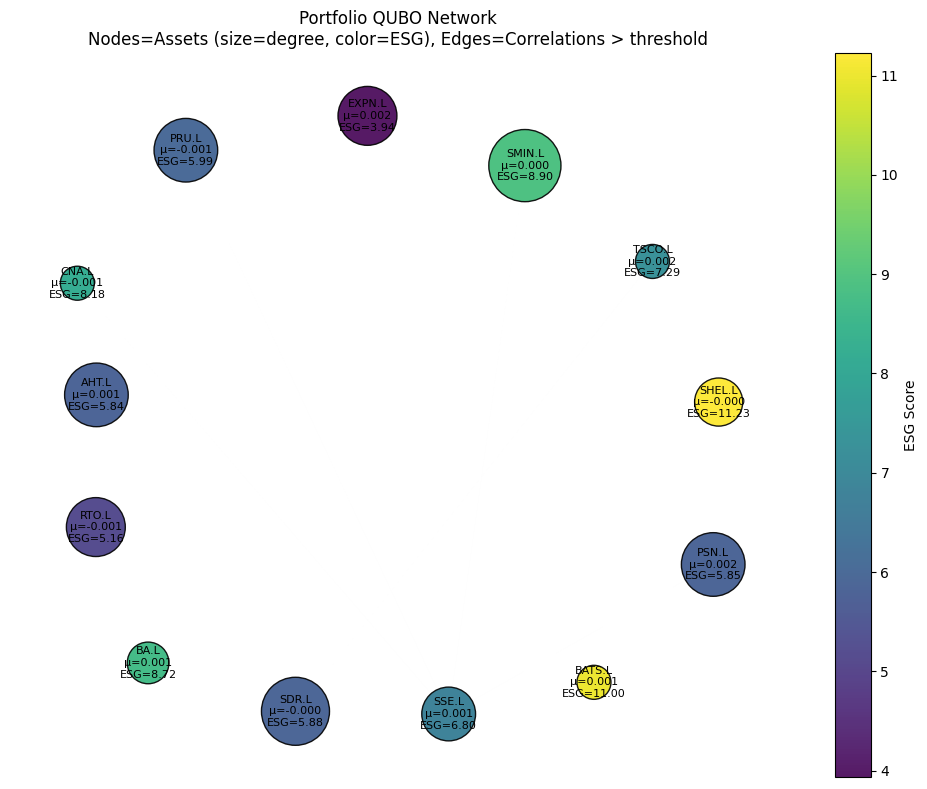


QUBO Matrix shape: (13, 13)
QUBO matrix ready for QAOA optimization!

=== Portfolio Characteristics ===
Assets: ['EXPN.L', 'SHEL.L', 'BA.L', 'CNA.L', 'TSCO.L', 'PRU.L', 'PSN.L', 'SDR.L', 'AHT.L', 'SSE.L', 'BATS.L', 'RTO.L', 'SMIN.L']
Expected returns: [np.float64(0.0017688016843327835), np.float64(-0.00011559472460823162), np.float64(0.0010055313925331148), np.float64(-0.0007076853674331382), np.float64(0.0015267701232890907), np.float64(-0.0006586712628688531), np.float64(0.0022173104459687846), np.float64(-0.00016156697892266882), np.float64(0.0009545854984969102), np.float64(0.001001579468659664), np.float64(0.0008588175027640563), np.float64(-0.0014477392263931724), np.float64(0.0004153361750701506)]
ESG scores: [np.float64(3.936666666666666), np.float64(11.226666666666667), np.float64(8.716666666666667), np.float64(8.18), np.float64(7.286666666666666), np.float64(5.989999999999999), np.float64(5.853333333333334), np.float64(5.876666666666666), np.float64(5.843333333333334), np.fl

In [7]:
# add the parent directory to Python path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

# load test json in jupyter notebook
import json
with open("./small_dataset.json") as f:
    dic = json.load(f)
    dic = dic["data"] # when run Launcher.ipynb, comment this out

# Parse data into assets and
from utils import json_parse
price_df, esg_s, asset_arr = json_parse(dic)

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

def create_qubo_graph(price_df, esg_s, asset_arr, correlation_threshold=0.3):
    """
    Create a QUBO graph from financial data
    
    Parameters:
    - price_df: DataFrame with price data (assets as columns)
    - esg_s: Series with ESG scores for each asset
    - asset_arr: Array of asset names/identifiers
    - correlation_threshold: Minimum correlation to include edge
    """
    # Calculate returns and correlation matrix - FIXED LINE
    returns_df = price_df.pct_change(fill_method=None).dropna()  # Explicitly disable filling
    correlation_matrix = returns_df.corr()
    covariance_matrix = returns_df.cov()
    
    # Calculate expected returns (mean returns)
    expected_returns = returns_df.mean()
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes with attributes
    for i, asset in enumerate(asset_arr):
        G.add_node(i, 
                  asset_name=asset,
                  mu=expected_returns.iloc[i] if i < len(expected_returns) else 0,
                  esg=esg_s.iloc[i] if i < len(esg_s) else 0)
    
    # Add edges based on correlation
    for i in range(len(asset_arr)):
        for j in range(i+1, len(asset_arr)):
            corr = correlation_matrix.iloc[i, j]
            cov = covariance_matrix.iloc[i, j]
            
            # Only add edges for significant correlations
            if abs(corr) > correlation_threshold:
                G.add_edge(i, j, weight=cov, correlation=corr)
    
    return G

def plot_qubo_graph(G, pos=None, node_size_scale=500):
    plt.figure(figsize=(10, 8))
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    # Parameters - using ESG scores for node coloring
    node_color = [G.nodes[i].get("esg", 0) for i in G.nodes()]
    node_size = [G.degree(i) * node_size_scale for i in G.nodes()]
    edge_width = [abs(G[u][v].get("weight", 0)) * 5 for u, v in G.edges()]  # Scaled for visibility

    # Draw nodes with ESG-based coloring
    nodes = nx.draw_networkx_nodes(G, pos, 
                                 node_color=node_color, 
                                 node_size=node_size, 
                                 alpha=0.9, 
                                 edgecolors="black",
                                 cmap='viridis')
    
    # Add colorbar for ESG scores
    plt.colorbar(nodes, label='ESG Score')
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, edge_color='gray')
    
    # Label nodes with parameters
    labels = {
        i: f"{G.nodes[i].get('asset_name', f'A{i}')}\nμ={G.nodes[i].get('mu', 0):.3f}\nESG={G.nodes[i].get('esg', 0):.2f}"
        for i in G.nodes()
    }
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    # Edge weight labels (optional - can be commented out for dense graphs)
    if len(G.edges()) < 20:  # Only show edge labels for sparse graphs
        edge_labels = {(u, v): f"{G[u][v].get('correlation', 0):.2f}" for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.axis('off')
    plt.title("Portfolio QUBO Network\nNodes=Assets (size=degree, color=ESG), Edges=Correlations > threshold")
    plt.tight_layout()
    plt.show()
    
    return pos

# Additional analysis functions
def analyze_graph_structure(G):
    """Analyze the graph structure for portfolio insights"""
    print("=== Portfolio Graph Analysis ===")
    print(f"Number of assets (nodes): {G.number_of_nodes()}")
    print(f"Number of correlations (edges): {G.number_of_edges()}")
    print(f"Graph density: {nx.density(G):.3f}")
    
    # Degree analysis
    degrees = [G.degree(i) for i in G.nodes()]
    print(f"Average connections per asset: {np.mean(degrees):.2f}")
    
    # ESG analysis
    esg_scores = [G.nodes[i].get('esg', 0) for i in G.nodes()]
    print(f"Average ESG score: {np.mean(esg_scores):.2f}")
    
    # Correlation analysis
    correlations = [G[u][v].get('correlation', 0) for u, v in G.edges()]
    print(f"Average absolute correlation: {np.mean(np.abs(correlations)):.3f}")
    
    # Identify highly connected assets (potential diversification hubs)
    high_degree_assets = sorted([(G.nodes[i].get('asset_name', f'A{i}'), G.degree(i)) 
                               for i in G.nodes()], key=lambda x: x[1], reverse=True)[:3]
    print(f"Most connected assets: {high_degree_assets}")

def create_qubo_matrix(G, risk_aversion=0.5, esg_weight=0.1):
    """
    Create QUBO matrix from graph for QAOA optimization
    
    QUBO formulation for portfolio optimization:
    min ∑ᵢ(-μᵢ + λσᵢ²)xᵢ + ∑ᵢ∑ⱼ(λσᵢⱼ)xᵢxⱼ - α⋅ESGᵢxᵢ
    """
    n_assets = G.number_of_nodes()
    Q = np.zeros((n_assets, n_assets))
    
    for i in range(n_assets):
        # Linear terms: -return + risk_aversion*variance - esg_weight*esg
        mu_i = G.nodes[i].get('mu', 0)
        esg_i = G.nodes[i].get('esg', 0)
        
        # Estimate variance from neighbors (simplified)
        variance_estimate = sum(abs(G[i][j].get('weight', 0)) for j in G.neighbors(i)) if list(G.neighbors(i)) else 0.01
        
        Q[i,i] = -mu_i + risk_aversion * variance_estimate - esg_weight * esg_i
    
    # Quadratic terms: risk_aversion * covariance
    for i, j in G.edges():
        cov_ij = G[i][j].get('weight', 0)
        Q[i,j] = risk_aversion * cov_ij
        Q[j,i] = risk_aversion * cov_ij
    
    return Q

# Main execution
if __name__ == "__main__":
    # Create the QUBO graph from your data
    portfolio_graph = create_qubo_graph(price_df, esg_s, asset_arr, correlation_threshold=0.2)
    
    # Analyze the graph structure
    analyze_graph_structure(portfolio_graph)
    
    # Plot the graph
    print("\n=== Generating QUBO Network Visualization ===")
    graph_pos = plot_qubo_graph(portfolio_graph, node_size_scale=300)
    
    # Create QUBO matrix for QAOA
    qubo_matrix = create_qubo_matrix(portfolio_graph)
    print(f"\nQUBO Matrix shape: {qubo_matrix.shape}")
    print("QUBO matrix ready for QAOA optimization!")
    
    # Optional: Display some portfolio statistics
    print("\n=== Portfolio Characteristics ===")
    print(f"Assets: {[portfolio_graph.nodes[i].get('asset_name', f'A{i}') for i in portfolio_graph.nodes()]}")
    print(f"Expected returns: {[portfolio_graph.nodes[i].get('mu', 0) for i in portfolio_graph.nodes()]}")
    print(f"ESG scores: {[portfolio_graph.nodes[i].get('esg', 0) for i in portfolio_graph.nodes()]}")

=== Correlation Analysis ===
Correlation matrix shape: (13, 13)
Correlation range: [-0.003, 1.000]

All correlations:
EXPN.L vs SHEL.L: 0.116
EXPN.L vs BA.L: 0.100
EXPN.L vs CNA.L: 0.048
EXPN.L vs TSCO.L: 0.056
EXPN.L vs PRU.L: 0.332
EXPN.L vs PSN.L: 0.416
EXPN.L vs SDR.L: 0.430
EXPN.L vs AHT.L: 0.366
EXPN.L vs SSE.L: 0.177
EXPN.L vs BATS.L: 0.073
EXPN.L vs RTO.L: 0.263
EXPN.L vs SMIN.L: 0.371
SHEL.L vs BA.L: 0.273
SHEL.L vs CNA.L: 0.173
SHEL.L vs TSCO.L: 0.080
SHEL.L vs PRU.L: 0.170
SHEL.L vs PSN.L: 0.054
SHEL.L vs SDR.L: 0.193
SHEL.L vs AHT.L: 0.228
SHEL.L vs SSE.L: 0.098
SHEL.L vs BATS.L: 0.211
SHEL.L vs RTO.L: 0.092
SHEL.L vs SMIN.L: 0.259
BA.L vs CNA.L: 0.201
BA.L vs TSCO.L: 0.052
BA.L vs PRU.L: 0.092
BA.L vs PSN.L: 0.048
BA.L vs SDR.L: 0.146
BA.L vs AHT.L: 0.066
BA.L vs SSE.L: 0.074
BA.L vs BATS.L: 0.117
BA.L vs RTO.L: 0.122
BA.L vs SMIN.L: 0.271
CNA.L vs TSCO.L: 0.102
CNA.L vs PRU.L: 0.167
CNA.L vs PSN.L: 0.116
CNA.L vs SDR.L: 0.181
CNA.L vs AHT.L: 0.042
CNA.L vs SSE.L: 0.388
CN

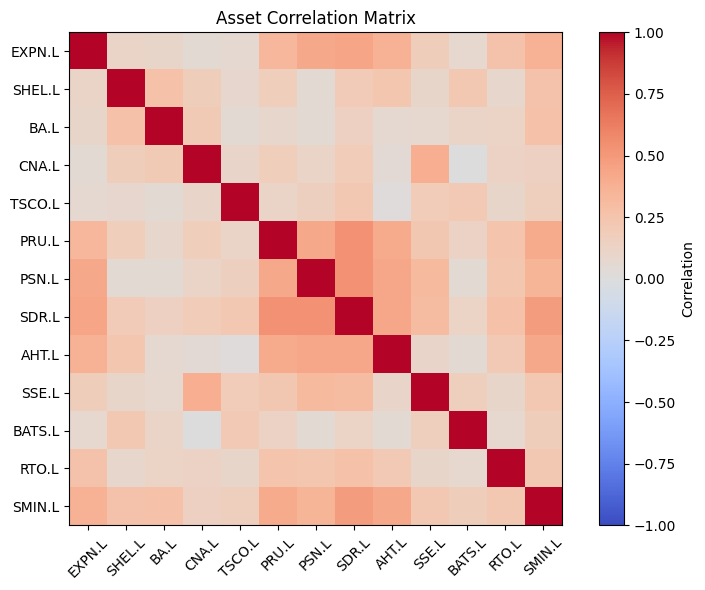

In [8]:
# First, let's diagnose the correlation structure
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

def diagnose_correlations(price_df, asset_arr):
    """Analyze why no edges are being created"""
    returns_df = price_df.pct_change(fill_method=None).dropna()
    correlation_matrix = returns_df.corr()
    
    print("=== Correlation Analysis ===")
    print(f"Correlation matrix shape: {correlation_matrix.shape}")
    print(f"Correlation range: [{correlation_matrix.min().min():.3f}, {correlation_matrix.max().max():.3f}]")
    
    # Show all correlations
    print("\nAll correlations:")
    for i in range(len(asset_arr)):
        for j in range(i+1, len(asset_arr)):
            corr = correlation_matrix.iloc[i, j]
            print(f"{asset_arr[i]} vs {asset_arr[j]}: {corr:.3f}")
    
    # Plot correlation heatmap
    plt.figure(figsize=(8, 6))
    im = plt.imshow(correlation_matrix.values, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, label='Correlation')
    plt.xticks(range(len(asset_arr)), asset_arr, rotation=45)
    plt.yticks(range(len(asset_arr)), asset_arr)
    plt.title('Asset Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

# Run diagnosis first
correlation_matrix = diagnose_correlations(price_df, asset_arr)

Edges added with threshold 0.05: 72
=== Portfolio Graph Analysis ===
Number of assets (nodes): 13
Number of correlations (edges): 34
Graph density: 0.436
Average connections per asset: 5.23
Average ESG score: 7.29
Average absolute correlation: 0.325
Most connected assets: [('SMIN.L', 9), ('SDR.L', 8), ('PRU.L', 7)]

=== Generating QUBO Network Visualization ===


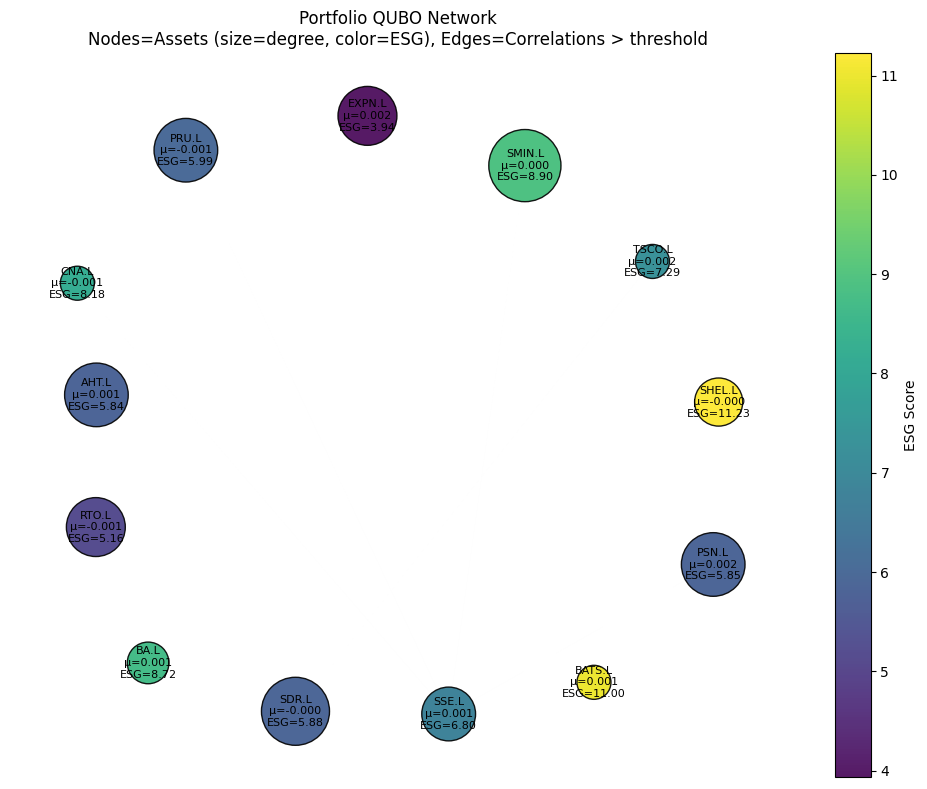


QUBO Matrix shape: (13, 13)
QUBO matrix ready for QAOA optimization!

=== Portfolio Characteristics ===
Assets: ['EXPN.L', 'SHEL.L', 'BA.L', 'CNA.L', 'TSCO.L', 'PRU.L', 'PSN.L', 'SDR.L', 'AHT.L', 'SSE.L', 'BATS.L', 'RTO.L', 'SMIN.L']
Expected returns: [np.float64(0.0017688016843327835), np.float64(-0.00011559472460823162), np.float64(0.0010055313925331148), np.float64(-0.0007076853674331382), np.float64(0.0015267701232890907), np.float64(-0.0006586712628688531), np.float64(0.0022173104459687846), np.float64(-0.00016156697892266882), np.float64(0.0009545854984969102), np.float64(0.001001579468659664), np.float64(0.0008588175027640563), np.float64(-0.0014477392263931724), np.float64(0.0004153361750701506)]
ESG scores: [np.float64(3.936666666666666), np.float64(11.226666666666667), np.float64(8.716666666666667), np.float64(8.18), np.float64(7.286666666666666), np.float64(5.989999999999999), np.float64(5.853333333333334), np.float64(5.876666666666666), np.float64(5.843333333333334), np.fl

In [9]:
# add the parent directory to Python path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

# load test json in jupyter notebook
import json
with open("./small_dataset.json") as f:
    dic = json.load(f)
    dic = dic["data"] # when run Launcher.ipynb, comment this out

# Parse data into assets and
from utils import json_parse
price_df, esg_s, asset_arr = json_parse(dic)

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

def create_qubo_graph_low_threshold(price_df, esg_s, asset_arr, correlation_threshold=0.1):  # Lower threshold
    """
    Create graph with lower correlation threshold
    """
    returns_df = price_df.pct_change(fill_method=None).dropna()
    correlation_matrix = returns_df.corr()
    covariance_matrix = returns_df.cov()
    expected_returns = returns_df.mean()
    
    G = nx.Graph()
    
    # Add nodes
    for i, asset in enumerate(asset_arr):
        G.add_node(i, 
                  asset_name=asset,
                  mu=expected_returns.iloc[i] if i < len(expected_returns) else 0,
                  esg=esg_s.iloc[i] if i < len(esg_s) else 0)
    
    # Add edges with lower threshold
    edges_added = 0
    for i in range(len(asset_arr)):
        for j in range(i+1, len(asset_arr)):
            corr = correlation_matrix.iloc[i, j]
            cov = covariance_matrix.iloc[i, j]
            
            if abs(corr) > correlation_threshold:  # Much lower threshold
                G.add_edge(i, j, weight=cov, correlation=corr)
                edges_added += 1
    
    print(f"Edges added with threshold {correlation_threshold}: {edges_added}")
    return G

# Try with very low threshold
portfolio_graph = create_qubo_graph_low_threshold(price_df, esg_s, asset_arr, correlation_threshold=0.05)

def plot_qubo_graph(G, pos=None, node_size_scale=500):
    plt.figure(figsize=(10, 8))
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    # Parameters - using ESG scores for node coloring
    node_color = [G.nodes[i].get("esg", 0) for i in G.nodes()]
    node_size = [G.degree(i) * node_size_scale for i in G.nodes()]
    edge_width = [abs(G[u][v].get("weight", 0)) * 5 for u, v in G.edges()]  # Scaled for visibility

    # Draw nodes with ESG-based coloring
    nodes = nx.draw_networkx_nodes(G, pos, 
                                 node_color=node_color, 
                                 node_size=node_size, 
                                 alpha=0.9, 
                                 edgecolors="black",
                                 cmap='viridis')
    
    # Add colorbar for ESG scores
    plt.colorbar(nodes, label='ESG Score')
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, edge_color='gray')
    
    # Label nodes with parameters
    labels = {
        i: f"{G.nodes[i].get('asset_name', f'A{i}')}\nμ={G.nodes[i].get('mu', 0):.3f}\nESG={G.nodes[i].get('esg', 0):.2f}"
        for i in G.nodes()
    }
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    # Edge weight labels (optional - can be commented out for dense graphs)
    if len(G.edges()) < 20:  # Only show edge labels for sparse graphs
        edge_labels = {(u, v): f"{G[u][v].get('correlation', 0):.2f}" for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.axis('off')
    plt.title("Portfolio QUBO Network\nNodes=Assets (size=degree, color=ESG), Edges=Correlations > threshold")
    plt.tight_layout()
    plt.show()
    
    return pos

# Additional analysis functions
def analyze_graph_structure(G):
    """Analyze the graph structure for portfolio insights"""
    print("=== Portfolio Graph Analysis ===")
    print(f"Number of assets (nodes): {G.number_of_nodes()}")
    print(f"Number of correlations (edges): {G.number_of_edges()}")
    print(f"Graph density: {nx.density(G):.3f}")
    
    # Degree analysis
    degrees = [G.degree(i) for i in G.nodes()]
    print(f"Average connections per asset: {np.mean(degrees):.2f}")
    
    # ESG analysis
    esg_scores = [G.nodes[i].get('esg', 0) for i in G.nodes()]
    print(f"Average ESG score: {np.mean(esg_scores):.2f}")
    
    # Correlation analysis
    correlations = [G[u][v].get('correlation', 0) for u, v in G.edges()]
    print(f"Average absolute correlation: {np.mean(np.abs(correlations)):.3f}")
    
    # Identify highly connected assets (potential diversification hubs)
    high_degree_assets = sorted([(G.nodes[i].get('asset_name', f'A{i}'), G.degree(i)) 
                               for i in G.nodes()], key=lambda x: x[1], reverse=True)[:3]
    print(f"Most connected assets: {high_degree_assets}")

def create_qubo_matrix(G, risk_aversion=0.5, esg_weight=0.1):
    """
    Create QUBO matrix from graph for QAOA optimization
    
    QUBO formulation for portfolio optimization:
    min ∑ᵢ(-μᵢ + λσᵢ²)xᵢ + ∑ᵢ∑ⱼ(λσᵢⱼ)xᵢxⱼ - α⋅ESGᵢxᵢ
    """
    n_assets = G.number_of_nodes()
    Q = np.zeros((n_assets, n_assets))
    
    for i in range(n_assets):
        # Linear terms: -return + risk_aversion*variance - esg_weight*esg
        mu_i = G.nodes[i].get('mu', 0)
        esg_i = G.nodes[i].get('esg', 0)
        
        # Estimate variance from neighbors (simplified)
        variance_estimate = sum(abs(G[i][j].get('weight', 0)) for j in G.neighbors(i)) if list(G.neighbors(i)) else 0.01
        
        Q[i,i] = -mu_i + risk_aversion * variance_estimate - esg_weight * esg_i
    
    # Quadratic terms: risk_aversion * covariance
    for i, j in G.edges():
        cov_ij = G[i][j].get('weight', 0)
        Q[i,j] = risk_aversion * cov_ij
        Q[j,i] = risk_aversion * cov_ij
    
    return Q

# Main execution
if __name__ == "__main__":
    # Create the QUBO graph from your data
    portfolio_graph = create_qubo_graph(price_df, esg_s, asset_arr, correlation_threshold=0.2)
    
    # Analyze the graph structure
    analyze_graph_structure(portfolio_graph)
    
    # Plot the graph
    print("\n=== Generating QUBO Network Visualization ===")
    graph_pos = plot_qubo_graph(portfolio_graph, node_size_scale=300)
    
    # Create QUBO matrix for QAOA
    qubo_matrix = create_qubo_matrix(portfolio_graph)
    print(f"\nQUBO Matrix shape: {qubo_matrix.shape}")
    print("QUBO matrix ready for QAOA optimization!")
    
    # Optional: Display some portfolio statistics
    print("\n=== Portfolio Characteristics ===")
    print(f"Assets: {[portfolio_graph.nodes[i].get('asset_name', f'A{i}') for i in portfolio_graph.nodes()]}")
    print(f"Expected returns: {[portfolio_graph.nodes[i].get('mu', 0) for i in portfolio_graph.nodes()]}")
    print(f"ESG scores: {[portfolio_graph.nodes[i].get('esg', 0) for i in portfolio_graph.nodes()]}")

In [16]:
import numpy as np
import pandas as pd
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit.primitives import Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit import transpile
from qiskit_aer import Aer

# --- QUBO to Ising Hamiltonian conversion ---
def qubo_to_ising_hamiltonian(Q):
    """
    Convert QUBO matrix to Ising Hamiltonian for QAOA
    QUBO: min x^T Q x where x in {0,1}^n
    Ising: min sum h_i Z_i + sum J_ij Z_i Z_j
    Mapping: x_i = (1 - Z_i)/2
    """
    n = Q.shape[0]
    
    # Linear terms (h_i)
    h = np.zeros(n)
    for i in range(n):
        h[i] = -0.5 * Q[i, i] - 0.25 * np.sum([Q[i, j] + Q[j, i] for j in range(n) if j != i])
    
    # Quadratic terms (J_ij)
    J = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            J[i, j] = 0.25 * Q[i, j]
    
    return h, J

# --- Build SparsePauliOp from Ising model ---
def build_hamiltonian_from_ising(h, J):
    """Create SparsePauliOp from Ising coefficients"""
    n = len(h)
    pauli_list = []
    
    # Linear terms: h_i * Z_i
    for i in range(n):
        pauli_str = ['I'] * n
        pauli_str[i] = 'Z'
        pauli_list.append((''.join(pauli_str), h[i]))
    
    # Quadratic terms: J_ij * Z_i Z_j
    for i in range(n):
        for j in range(i+1, n):
            if abs(J[i, j]) > 1e-10:
                pauli_str = ['I'] * n
                pauli_str[i] = 'Z'
                pauli_str[j] = 'Z'
                pauli_list.append((''.join(pauli_str), J[i, j]))
    
    return SparsePauliOp.from_list(pauli_list)

# --- Evaluate portfolio metrics ---
def evaluate_bitstring_metrics(x, price_df, esg_s):
    """Evaluate portfolio performance for a given bitstring selection"""
    if sum(x) == 0:
        return {"roi": 0.0, "risk": 0.0, "esg": 0.0, "sharpe": 0.0}
    
    # Calculate returns
    returns_df = price_df.pct_change(fill_method=None).dropna()
    mu_daily = returns_df.mean()
    mu_annual = mu_daily * 252
    Sigma_annual = returns_df.cov() * 252
    
    # Equal weighting among selected assets
    weights = np.array(x) / sum(x)
    
    # Portfolio metrics
    roi = float(np.dot(mu_annual.values, weights))
    risk = float(weights.T @ Sigma_annual.values @ weights)
    sharpe = roi / np.sqrt(risk) if risk > 0 else 0
    
    # ESG score (weighted average)
    if isinstance(esg_s, (pd.Series, pd.DataFrame)):
        esg_vals = esg_s.values.flatten()
    else:
        esg_vals = np.array(esg_s)
    
    # Ensure esg_vals matches the length of weights
    if len(esg_vals) > len(weights):
        esg_vals = esg_vals[:len(weights)]
    elif len(esg_vals) < len(weights):
        esg_vals = np.pad(esg_vals, (0, len(weights) - len(esg_vals)))
    
    esg_score = float(np.dot(esg_vals, weights))
    
    return {
        "roi": roi, 
        "risk": risk, 
        "esg": esg_score, 
        "sharpe": sharpe,
        "num_assets": sum(x)
    }

# --- Core QAOA optimization function ---
def run_qaoa_portfolio_optimization(qubo_matrix, price_df, esg_s, reps=2, optimizer_type='COBYLA', maxiter=100, shots=1024):
    """
    Complete QAOA workflow for portfolio optimization
    """
    print("=== QAOA Portfolio Optimization ===")
    print(f"Assets: {qubo_matrix.shape[0]}, QAOA layers: {reps}")
    
    # 1. Convert QUBO to Hamiltonian
    h, J = qubo_to_ising_hamiltonian(qubo_matrix)
    hamiltonian = build_hamiltonian_from_ising(h, J)
    print("✓ Hamiltonian constructed")
    
    # 2. Set up optimizer
    if optimizer_type.upper() == 'COBYLA':
        optimizer = COBYLA(maxiter=maxiter)
    else:
        optimizer = SPSA(maxiter=maxiter)
    
    # 3. Run QAOA using modern primitives
    print("Running QAOA optimization...")
    sampler = Sampler()
    qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=reps)
    
    result = qaoa.compute_minimum_eigenvalue(hamiltonian)
    print("✓ QAOA optimization completed")
    
    # 4. Create QAOA circuit with optimal parameters and sample
    print("Sampling results...")
    backend = Aer.get_backend('qasm_simulator')
    
    # Create QAOA ansatz with optimal parameters
    optimal_point = result.optimal_point
    ansatz = QAOAAnsatz(hamiltonian, reps=reps)
    
    # Bind parameters correctly
    parameter_dict = {}
    for i, param in enumerate(ansatz.parameters):
        parameter_dict[param] = optimal_point[i]
    
    optimal_circuit = ansatz.assign_parameters(parameter_dict)
    
    # Add measurements and run
    measured_circuit = optimal_circuit.copy()
    measured_circuit.measure_all()
    transpiled_circuit = transpile(measured_circuit, backend)
    job = backend.run(transpiled_circuit, shots=shots)
    counts = job.result().get_counts()
    
    # 5. Process results
    total_shots = sum(counts.values())
    samples = []
    
    for bitstring, count in counts.items():
        probability = count / total_shots
        # Convert bitstring to binary vector (qiskit uses little-endian)
        x_vector = [int(bit) for bit in bitstring[::-1]]  # Reverse for correct order
        
        metrics = evaluate_bitstring_metrics(x_vector, price_df, esg_s)
        samples.append({
            'bitstring': bitstring,
            'probability': probability,
            'x_vector': x_vector,
            **metrics
        })
    
    # Sort by probability (most likely solutions first)
    samples.sort(key=lambda x: x['probability'], reverse=True)
    
    # 6. Classical verification (optional)
    print("Running classical verification...")
    classical_solver = NumPyMinimumEigensolver()
    classical_result = classical_solver.compute_minimum_eigenvalue(hamiltonian)
    classical_energy = classical_result.eigenvalue.real
    
    return {
        'qaoa_result': result,
        'classical_energy': classical_energy,
        'optimal_parameters': optimal_point,
        'samples': samples[:10],  # Top 10 results
        'hamiltonian': hamiltonian,
        'all_samples': samples
    }

# --- Graph to QUBO mapping ---
def graph_to_qubo_with_objectives(G, risk_aversion=0.5, esg_weight=0.1, budget_weight=1.0, target_budget=None):
    """
    Convert graph to QUBO matrix with portfolio objectives
    """
    n_assets = G.number_of_nodes()
    
    if target_budget is None:
        target_budget = n_assets // 2  # Default: select half the assets
    
    Q = np.zeros((n_assets, n_assets))
    
    # Linear terms
    for i in range(n_assets):
        mu_i = G.nodes[i].get('mu', 0)
        esg_i = G.nodes[i].get('esg', 0)
        
        # Estimate variance from graph edges
        variance_est = sum(abs(G[i][j].get('weight', 0)) for j in G.neighbors(i)) if list(G.neighbors(i)) else 0.01
        
        Q[i, i] = (-mu_i + risk_aversion * variance_est - esg_weight * esg_i + 
                   budget_weight * (1 - 2 * target_budget))
    
    # Quadratic terms
    for i, j in G.edges():
        cov_ij = G[i][j].get('weight', 0)
        Q[i, j] = risk_aversion * cov_ij + budget_weight
        Q[j, i] = risk_aversion * cov_ij + budget_weight
    
    # Additional budget constraint diagonal adjustment
    for i in range(n_assets):
        Q[i, i] += budget_weight
    
    return Q

# --- Create QUBO graph function (you need this from previous code) ---
def create_qubo_graph(price_df, esg_s, asset_arr, correlation_threshold=0.1):
    """
    Create a QUBO graph from financial data
    """
    returns_df = price_df.pct_change(fill_method=None).dropna()
    correlation_matrix = returns_df.corr()
    covariance_matrix = returns_df.cov()
    expected_returns = returns_df.mean()
    
    G = nx.Graph()
    
    # Add nodes
    for i, asset in enumerate(asset_arr):
        G.add_node(i, 
                  asset_name=asset,
                  mu=expected_returns.iloc[i] if i < len(expected_returns) else 0,
                  esg=esg_s.iloc[i] if i < len(esg_s) else 0)
    
    # Add edges based on correlation
    edges_added = 0
    for i in range(len(asset_arr)):
        for j in range(i+1, len(asset_arr)):
            corr = correlation_matrix.iloc[i, j]
            cov = covariance_matrix.iloc[i, j]
            
            if abs(corr) > correlation_threshold:
                G.add_edge(i, j, weight=cov, correlation=corr)
                edges_added += 1
    
    print(f"Graph created: {G.number_of_nodes()} nodes, {edges_added} edges")
    return G

# --- Complete workflow ---
def complete_qaoa_workflow(price_df, esg_s, asset_arr, correlation_threshold=0.1, reps=1):
    """End-to-end QAOA portfolio optimization workflow"""
    
    # 1. Create graph from data
    print("Step 1: Creating portfolio graph...")
    portfolio_graph = create_qubo_graph(price_df, esg_s, asset_arr, correlation_threshold)
    
    # 2. Convert graph to QUBO
    print("Step 2: Converting graph to QUBO matrix...")
    qubo_matrix = graph_to_qubo_with_objectives(portfolio_graph, 
                                               risk_aversion=0.5, 
                                               esg_weight=0.1,
                                               target_budget=len(asset_arr)//2)
    
    # 3. Run QAOA
    print("Step 3: Running QAOA optimization...")
    results = run_qaoa_portfolio_optimization(qubo_matrix, price_df, esg_s, reps=reps)
    
    return results, portfolio_graph, qubo_matrix

# --- Run the complete workflow ---
print("Starting QAOA Portfolio Optimization...")
try:
    results, graph, qubo = complete_qaoa_workflow(price_df, esg_s, asset_arr, reps=1)
    
    print("\n" + "="*60)
    print("TOP QAOA PORTFOLIO SOLUTIONS")
    print("="*60)
    
    for i, sample in enumerate(results['samples']):
        print(f"\n#{i+1} (Prob: {sample['probability']:.5f})")
        print(f"Selection: {sample['bitstring']}")
        print(f"Assets selected: {sample['num_assets']}")
        print(f"Expected ROI: {sample['roi']:.3f}")
        print(f"Risk (Variance): {sample['risk']:.5f}")
        print(f"ESG Score: {sample['esg']:.3f}")
        print(f"Sharpe Ratio: {sample['sharpe']:.3f}")
    
    print(f"\nClassical optimal energy: {results['classical_energy']:.4f}")
    print(f"QAOA optimal energy: {results['qaoa_result'].eigenvalue.real:.4f}")
    
except Exception as e:
    print(f"Error during optimization: {e}")
    print("Make sure you have networkx imported: import networkx as nx")

Starting QAOA Portfolio Optimization...
Step 1: Creating portfolio graph...
Graph created: 13 nodes, 57 edges
Step 2: Converting graph to QUBO matrix...
Step 3: Running QAOA optimization...
=== QAOA Portfolio Optimization ===
Assets: 13, QAOA layers: 1
✓ Hamiltonian constructed
Running QAOA optimization...


/tmp/ipykernel_3706/1733062787.py:120: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


✓ QAOA optimization completed
Sampling results...
Running classical verification...

TOP QAOA PORTFOLIO SOLUTIONS

#1 (Prob: 0.05957)
Selection: 1111101011110
Assets selected: 10
Expected ROI: 0.144
Risk (Variance): 0.01535
ESG Score: 7.896
Sharpe Ratio: 1.161

#2 (Prob: 0.03613)
Selection: 1111111011110
Assets selected: 11
Expected ROI: 0.127
Risk (Variance): 0.01622
ESG Score: 7.712
Sharpe Ratio: 0.998

#3 (Prob: 0.02539)
Selection: 1111100011110
Assets selected: 9
Expected ROI: 0.098
Risk (Variance): 0.01445
ESG Score: 8.123
Sharpe Ratio: 0.813

#4 (Prob: 0.02539)
Selection: 1111101011111
Assets selected: 11
Expected ROI: 0.171
Risk (Variance): 0.01531
ESG Score: 7.536
Sharpe Ratio: 1.384

#5 (Prob: 0.02051)
Selection: 1110101011110
Assets selected: 9
Expected ROI: 0.132
Risk (Variance): 0.01660
ESG Score: 8.018
Sharpe Ratio: 1.023

#6 (Prob: 0.01855)
Selection: 1111101111110
Assets selected: 11
Expected ROI: 0.116
Risk (Variance): 0.01648
ESG Score: 7.722
Sharpe Ratio: 0.901

#7 (P

In [19]:
pip install qiskit-machine-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 148.3 MB/s  0:00:00m0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:━━━━━━━━━━━━━━━━━━ 0/2 [scipy]
      Successfully uninstalled scipy-1.16.2━━━━━ 0/2 [scipy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [qiskit-machine-learning]-machine-learning]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytket-qiskit 0.72.0 requires qiskit>=2.2.0, but you have qiskit 1.4.2 which is incompatible.
pytket-qiskit 0.72.0 requires qiskit-aer>=0.17.1, but you have qiskit-aer 0.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from quantinuum_wrapper import QuantinuumWrapper
from pytket import Circuit
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import QuantumKernel
from sklearn.cluster import SpectralClustering
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def quantum_asset_pruning(correlation_matrix, esg_scores, num_clusters=10):
    """
    Quantum kernel-based clustering for asset pruning before optimization.
    Uses Qiskit QuantumKernel + Spectral clustering.
    """
    n = correlation_matrix.shape[0]
    
    # MODERN: Use Sampler primitive instead of QuantumInstance
    sampler = Sampler()
    qk = QuantumKernel(sampler=sampler)

    # Compute pairwise quantum kernel matrix based on correlation and ESG data
    kernel_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # Combine correlation and ESG into joint state (normalized)
            vec_i = np.hstack((correlation_matrix[i], esg_scores[i]))
            vec_j = np.hstack((correlation_matrix[j], esg_scores[j]))
            vec_i /= np.linalg.norm(vec_i) if np.linalg.norm(vec_i) > 0 else 1
            vec_j /= np.linalg.norm(vec_j) if np.linalg.norm(vec_j) > 0 else 1
            kernel_matrix[i, j] = qk.evaluate(x_vec=vec_i.reshape(1, -1), y_vec=vec_j.reshape(1, -1))

    # Apply quantum-inspired spectral clustering
    clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
    labels = clustering.fit_predict(kernel_matrix)

    # Select one representative (highest ESG) per cluster
    selected_assets = []
    for k in range(num_clusters):
        cluster_indices = np.where(labels == k)[0]
        if len(cluster_indices) > 0:
            best_idx = cluster_indices[np.argmax(esg_scores[cluster_indices])]
            selected_assets.append(best_idx)
    return np.array(selected_assets)


def quantum_feature_selection(assets, correlation_matrix, esg_scores, target_clusters=10):
    """
    Integrates quantum kernel pruning into the classical optimization pipeline.
    """
    print(f"\n⚛️ Running Quantum Feature Selection on {len(assets)} assets...")
    selected_idx = quantum_asset_pruning(correlation_matrix, esg_scores, num_clusters=target_clusters)
    reduced_assets = np.array(assets)[selected_idx]
    print(f"✅ Reduced asset universe to {len(reduced_assets)} representative assets.\n")
    return reduced_assets


def run_quantum_optimization_pipeline(input_data, solver_params, extra_arguments):
    """
    Integrated classical + quantum feature selection + quantum optimization pipeline.
    """
    from utils import Json_parse
    price_df, esg_s, asset_arr = Json_parse.json_parse(input_data)

    from utils import Pre_processing
    mu, Sigma = Pre_processing.compute_mu_sigma(price_df)
    plt.imshow(Sigma, interpolation="nearest"); plt.title("Covariance Matrix Σ"); plt.show()

    # -----------------------------------------
    # 🔹 STEP 1: Quantum Feature Selection
    # -----------------------------------------
    esg_arr = esg_s.loc[asset_arr].values
    selected_assets = quantum_feature_selection(asset_arr, Sigma, esg_arr, target_clusters=10)

    # Filter everything downstream
    selected_indices = [i for i, asset in enumerate(asset_arr) if asset in selected_assets]
    Sigma_reduced = Sigma[np.ix_(selected_indices, selected_indices)]
    mu_reduced = mu[selected_indices]
    esg_reduced = esg_arr[selected_indices]

    # -----------------------------------------
    # 🔹 STEP 2: Classical Portfolio Optimization
    # -----------------------------------------
    from utils import run_portfolio_optimization_suite
    config_example = {
        'compute_inputs': {'shrinkage': True},
        'scalarized_qp': {
            'lamb_grid': [0.5, 1.0, 2.0],
            'eta_grid': [0.0, 0.2, 0.5],
            'lb': 0.0, 'ub': 0.2, 'allow_short': False
        },
        'cvar': {
            'alpha': 0.90, 'lamb': 0.5, 'eta': 0.3, 'use_mu_in_obj': True
        }
    }
    results_dict = run_portfolio_optimization_suite(
        price_df[selected_assets], mu_reduced, Sigma_reduced,
        selected_assets, pd.Series(esg_reduced, index=selected_assets),
        config_example
    )
    print("\n--- Classical Optimization Results Summary ---")
    print(results_dict.keys())

    # -----------------------------------------
    # 🔹 STEP 3: Quantum QAOA Refinement
    # -----------------------------------------
    from utils import PortfolioOptimization, print_result
    
    q = 1  
    num_assets = len(mu_reduced)
    budget = num_assets // 2 
    
    # Create portfolio optimization problem
    portfolio = PortfolioOptimization(
        expected_returns=mu_reduced, 
        covariances=Sigma_reduced, 
        risk_factor=q,
        budget=budget, 
        esg_scores=pd.Series(esg_reduced),
        roi_factor=1, 
        esg_factor=0.01
    )
    qp = portfolio.to_quadratic_program()

    # MODERN: Setup QAOA with Sampler primitive
    cobyla = COBYLA(maxiter=250)
    
    # Option A: Use local simulator (recommended for testing)
    sampler = Sampler()
    qaoa_mes = QAOA(sampler=sampler, optimizer=cobyla, reps=3)
    
    # Option B: Use Quantinuum backend (if available)
    # provider = QuantinuumWrapper()
    # backend = provider.get_backend('H1-1E')
    # sampler = Sampler(backend=backend)  # MODERN: Use backend with Sampler
    # qaoa_mes = QAOA(sampler=sampler, optimizer=cobyla, reps=3)
    
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)
    
    print("\n=== QAOA Optimization Results ===")
    print(f"Optimal solution: {result.x}")
    print(f"Optimal value: {result.fval}")
    
    return {
        "classical_results": results_dict,
        "quantum_result": result,
        "selected_assets": selected_assets,
        "reduced_covariance": Sigma_reduced,
        "reduced_returns": mu_reduced
    }


# Alternative simplified version for smaller problems
def run_basic_quantum_optimization(price_df, esg_s, asset_arr, reps=2, maxiter=100):
    """
    Simplified quantum optimization pipeline without feature selection
    """
    from utils import Pre_processing
    mu, Sigma = Pre_processing.compute_mu_sigma(price_df)
    
    # Direct QAOA on all assets (for smaller datasets)
    from utils import PortfolioOptimization
    
    num_assets = len(asset_arr)
    budget = max(2, num_assets // 3)  # Select about 1/3 of assets
    
    portfolio = PortfolioOptimization(
        expected_returns=mu,
        covariances=Sigma,
        risk_factor=0.5,
        budget=budget,
        esg_scores=esg_s,
        roi_factor=1.0,
        esg_factor=0.1
    )
    
    qp = portfolio.to_quadratic_program()
    
    # MODERN QAOA setup
    sampler = Sampler()
    optimizer = COBYLA(maxiter=maxiter)
    qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=reps)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    
    print("Running QAOA optimization...")
    result = qaoa.solve(qp)
    
    # Analyze results
    selected_assets = [asset_arr[i] for i, val in enumerate(result.x) if val > 0.5]
    
    print(f"\n🎯 QAOA Portfolio Selection:")
    print(f"Assets selected: {len(selected_assets)}/{num_assets}")
    print(f"Selected assets: {selected_assets}")
    print(f"Objective value: {result.fval:.4f}")
    
    return {
        "optimal_solution": result.x,
        "selected_assets": selected_assets,
        "objective_value": result.fval
    }


# Quick test function
def test_quantum_kernel():
    """Test the quantum kernel functionality"""
    print("Testing Quantum Kernel...")
    
    # Create sample data
    correlation_matrix = np.random.rand(5, 5)
    esg_scores = np.random.rand(5)
    
    # Make correlation matrix symmetric
    correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2
    np.fill_diagonal(correlation_matrix, 1.0)
    
    try:
        selected_assets = quantum_asset_pruning(correlation_matrix, esg_scores, num_clusters=3)
        print(f"✅ Quantum kernel test passed. Selected {len(selected_assets)} assets.")
        return True
    except Exception as e:
        print(f"❌ Quantum kernel test failed: {e}")
        return False


# Main execution block
if __name__ == "__main__":
    print("🚀 Quantum Portfolio Optimization Pipeline")
    print("=" * 50)
    
    # Test quantum kernel first
    if test_quantum_kernel():
        print("\n✅ All systems ready for quantum optimization!")
    else:
        print("\n⚠️  Quantum kernel issues detected. Check your installation.")
    
    # Example usage pattern:
    # results = run_quantum_optimization_pipeline(your_data, solver_params, extra_args)
    # OR for quick testing:
    # basic_results = run_basic_quantum_optimization(price_df, esg_s, asset_arr)

ModuleNotFoundError: No module named 'quantinuum_wrapper'